# Kaggle score: 77.77% accuracy
# Winning score: 83.2% accuracy

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import nltk
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
train = pd.read_json("/content/drive/My Drive/Colab Notebooks/whats cooking/train.json")
test = pd.read_json("/content/drive/My Drive/Colab Notebooks/whats cooking/test.json")

In [3]:
print(train.shape)
train.head()

(39774, 3)


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
print(test.shape)
test.head()

(9944, 2)


,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [5]:
print(train.isnull().sum(),"\n")
print(train.isnull().sum())

id             0
cuisine        0
ingredients    0
dtype: int64 

id             0
cuisine        0
ingredients    0
dtype: int64


In [6]:
print(train.info(),"\n")
print(test.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB
None 



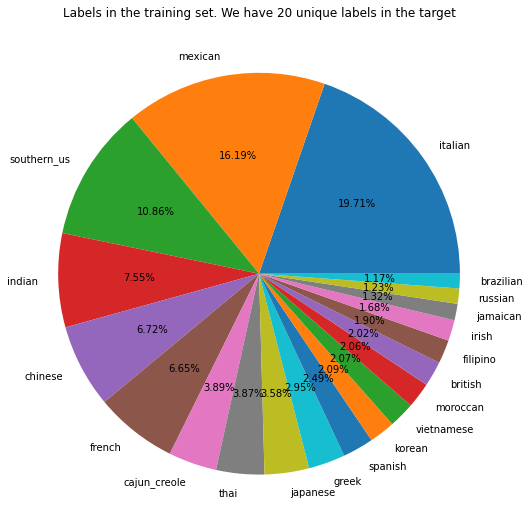

In [7]:
plt.figure(figsize=(9,10))
plt.pie(x=train["cuisine"].value_counts().to_dict().values(),labels=train["cuisine"].value_counts().to_dict().keys(),autopct='%1.2f%%')
plt.title("Labels in the training set. We have {} unique labels in the target".format(train["cuisine"].nunique()))
plt.show()

**Checking for duplicates**

In [8]:
train["ingredients_string"] = [", ".join(i) for i in train["ingredients"]]
train[["cuisine","ingredients_string"]][train[["id","cuisine","ingredients_string"]].duplicated()]

,cuisine,ingredients_string


In [9]:
#now we can drop ingredients_string; it was just for checking duplicates 
train.drop(["ingredients_string"],inplace=True,axis=1)

**Lets do some analysis and see how the ingredients look like and what are these ingredients. As of now it seems that the list of ingredients are pretty clean and wont require much pre-processing**<br>
Lets see the count of each ingredients that we have and see most common ones<br>
Plotting top 100 most common ingredients:

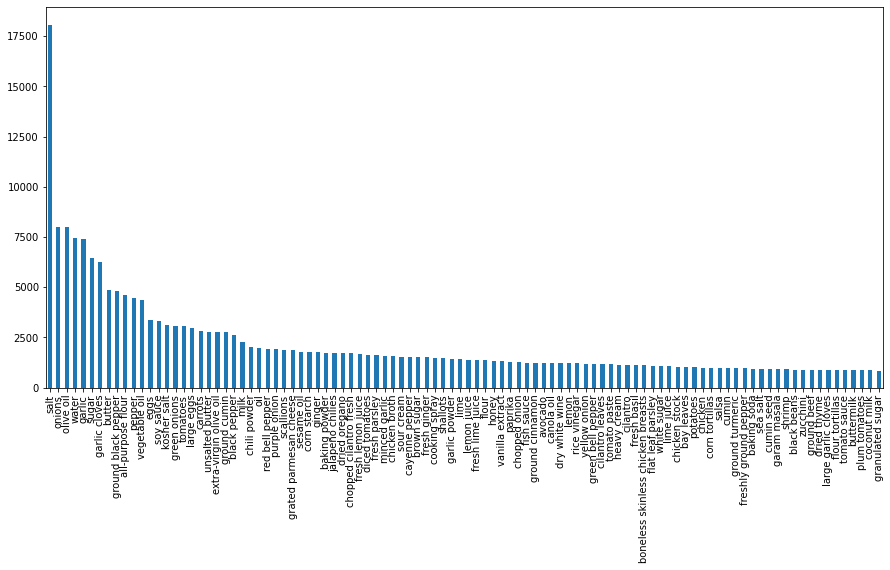

In [10]:
ingr=list()
for i in train["ingredients"]:
  for ing in i:
    ingr.append(ing)

ingr = pd.Series(ingr)
plt.figure(figsize=(15,7))
ingr.value_counts().head(100).plot.bar()

**Out of total ~40k recipes, salt is used in almost ~18k of them**<br><br>**Plotting 100 least common ingredients:**

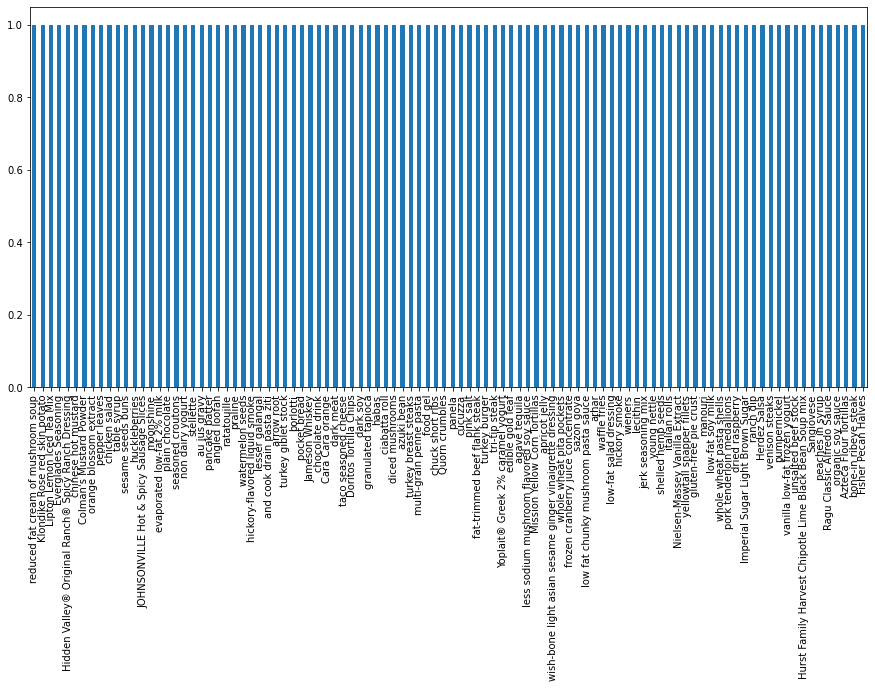

In [11]:
ingr=list()
for i in train["ingredients"]:
  for ing in i:
    ingr.append(ing)

ingr = pd.Series(ingr)
plt.figure(figsize=(15,7))
ingr.value_counts().tail(100).plot.bar()

**As we can see all these ingredients are used in just 1 recipe**<br><br>**Lets see how many ingredients do we have per recipe:**

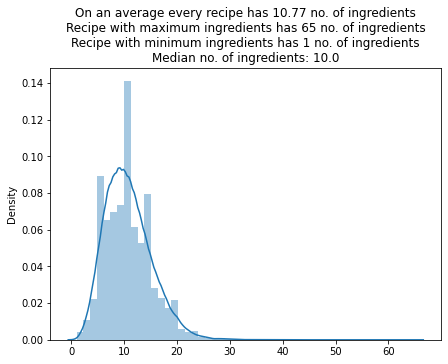

In [12]:
no_of_ingr = [len(x) for x in train["ingredients"]]
plt.figure(figsize=(7,5))
sns.distplot(no_of_ingr).set_title("On an average every recipe has "+str(round(np.mean(no_of_ingr),2))+" no. of ingredients\nRecipe with maximum ingredients has "+str(np.max(no_of_ingr))+" no. of ingredients\nRecipe with minimum ingredients has "+str(np.min(no_of_ingr))+" no. of ingredients\nMedian no. of ingredients: "+str(np.median(no_of_ingr)))
plt.show()

**Lets see no. of ingredients we have per cuisine, but first lets group ingredients cuisine wise:**

In [13]:
d = dict() 

for i in train.groupby("cuisine"):
  ingr_set = set()
  for lst in i[1]["ingredients"]:
    for ing in lst:
      ingr_set.add(ing.lower())
  
  d[i[0]] = list(ingr_set) 
  
print(d)

{'brazilian': ['boneless skin on chicken thighs', 'mayonaise', 'swiss cheese', 'cracked black pepper', 'coconut', 'skate wing', 'fresh tomatoes', 'yellow onion', 'açai', 'sherry wine', 'sambal ulek', 'curly kale', 'passion fruit juice', 'bacon slices', 'sweet corn', 'stock', 'sazon goya', 'light rum', 'turkey sausage', 'finely chopped onion', 'pimentos', 'ham', 'fresh corn', 'bacon', 'kiwi', 'beef stock', 'rolled oats', 'manchego cheese', 'grouper', 'toasted almonds', 'fresh mint', 'italian parsley leaves', 'sugarcane sticks', 'butternut squash', 'chocolate sprinkles', 'boneless skinless chicken breasts', 'dry coconut', 'short rib', 'bread crumbs', 'vanilla essence', 'sea bass fillets', 'butter oil', 'frozen corn', 'chili pepper', 'diced tomatoes', 'licor 43', 'coconut flour', 'dry red wine', 'table cream', 'fresh lemon juice', 'ground cinnamon', 'raw cashews', 'parsnips', 'homemade stock', 'chipotles in adobo', 'peanut oil', 'curry powder', 'broth', '2% reduced-fat milk', 'diced onion

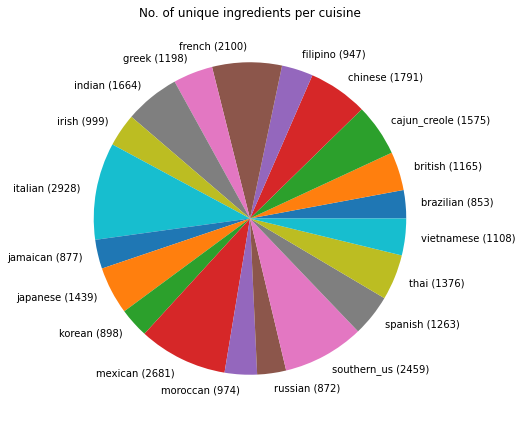

In [14]:
no_of_ingr_per_cuisine = {k:len(v) for k,v in d.items()}
plt.figure(figsize=(7,8))
plt.pie(x=no_of_ingr_per_cuisine.values(),labels=[k+" ("+str(v)+")" for k,v in no_of_ingr_per_cuisine.items()])
plt.title("No. of unique ingredients per cuisine")
plt.show()

**Lets see some statistics of ingredients per reciepe per cuisine:**

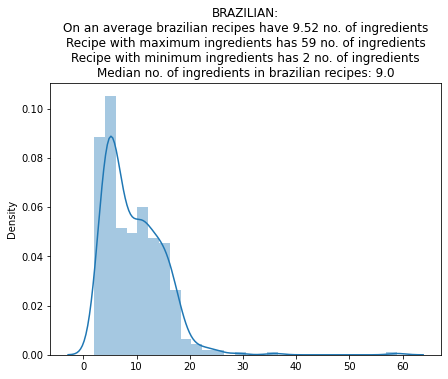

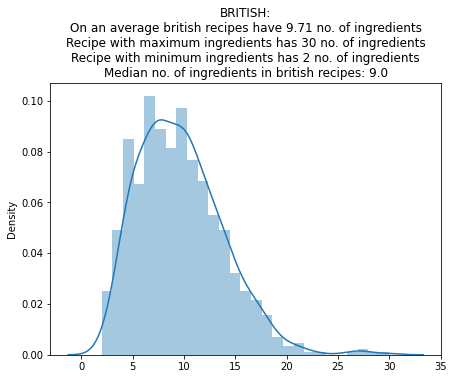

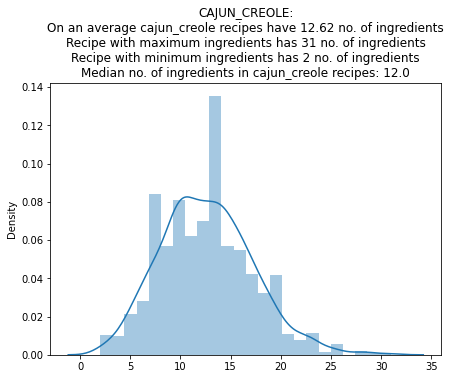

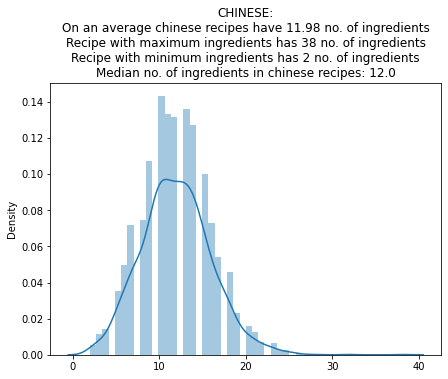

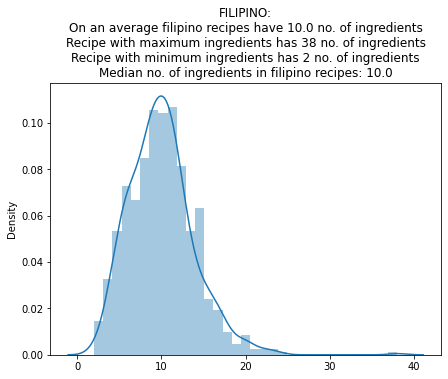

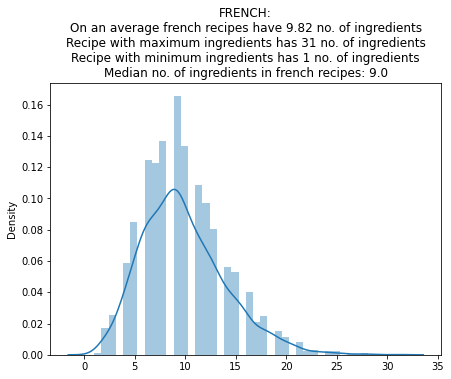

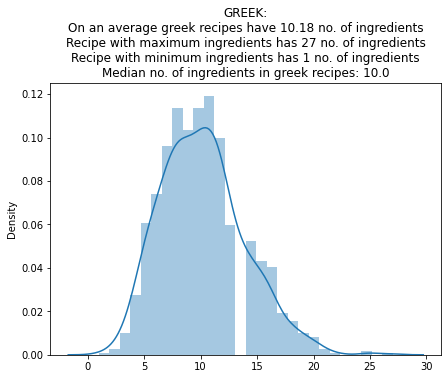

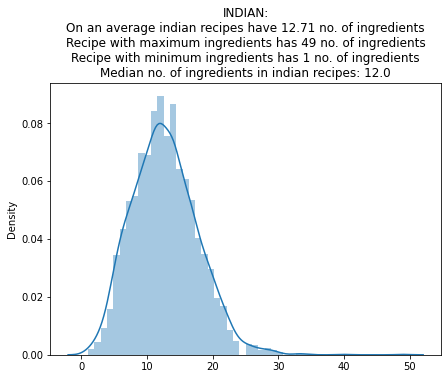

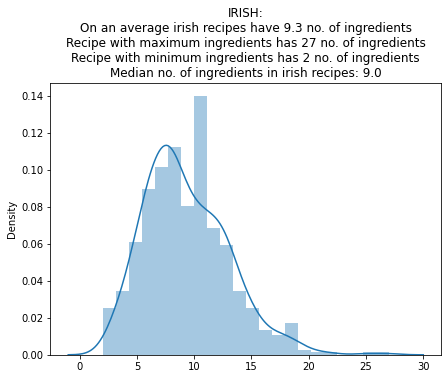

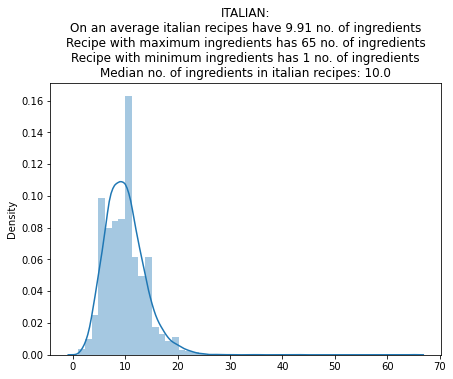

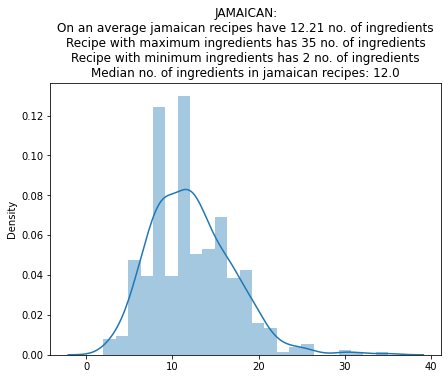

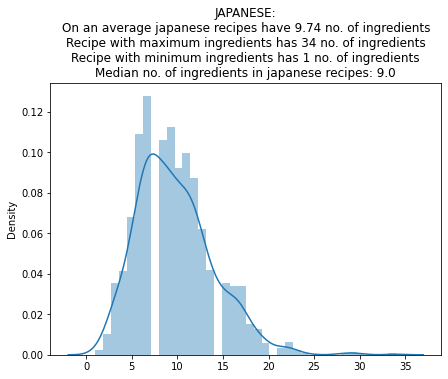

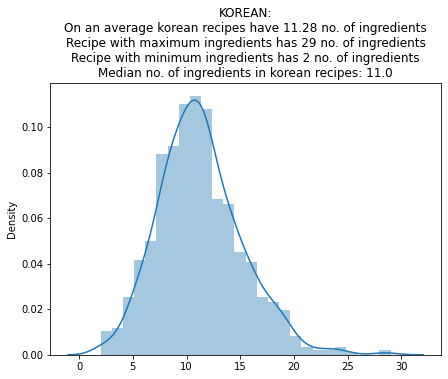

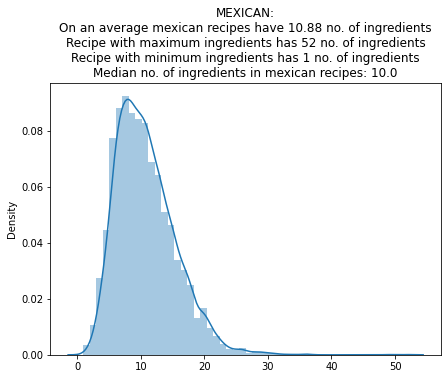

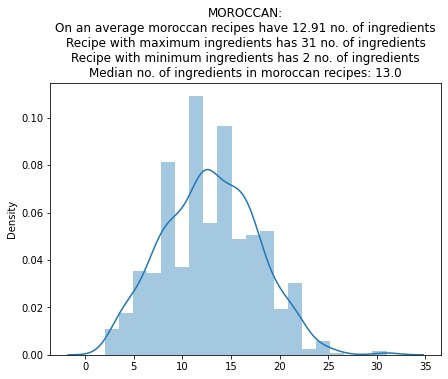

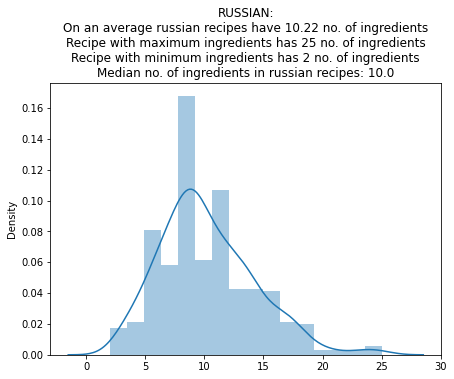

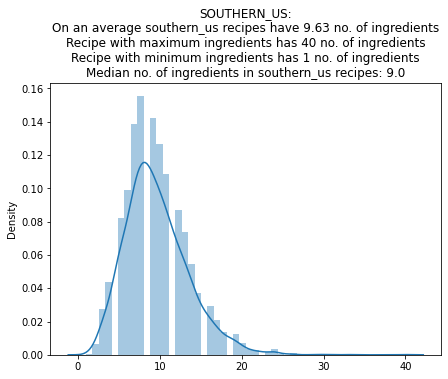

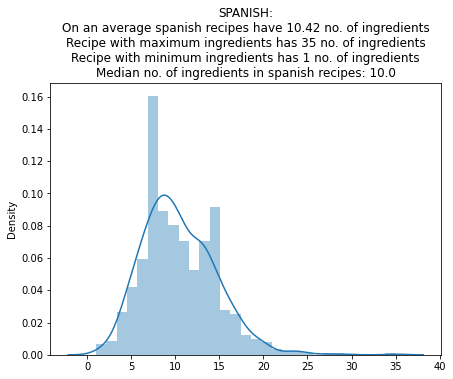

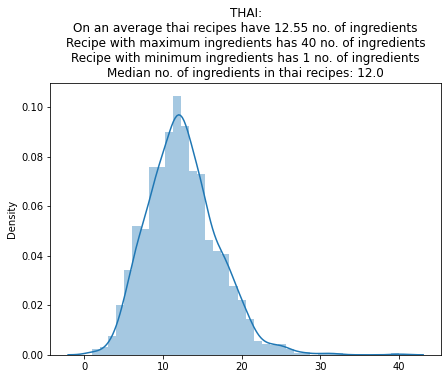

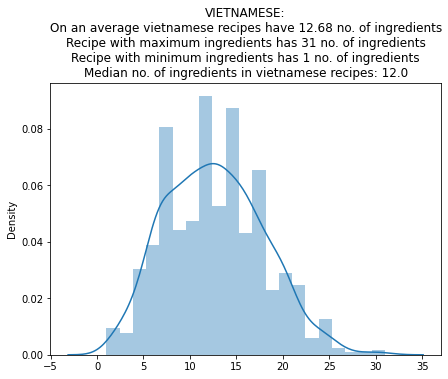

In [15]:
for i in train.groupby("cuisine"):
  no_of_ingr = [len(lst) for lst in i[1]["ingredients"]]
  plt.figure(figsize=(7,5))
  sns.distplot(no_of_ingr).set_title(i[0].upper()+":\nOn an average "+i[0]+" recipes have "+str(round(np.mean(no_of_ingr),2))+" no. of ingredients\nRecipe with maximum ingredients has "+str(np.max(no_of_ingr))+" no. of ingredients\nRecipe with minimum ingredients has "+str(np.min(no_of_ingr))+" no. of ingredients\nMedian no. of ingredients in "+i[0]+" recipes: "+str(np.median(no_of_ingr)))
  plt.show()

**Lets see if we have any unwanted characters in the ingredient names, ideally ingredients must only have alphabets; no digits, no special characters**<br> 
**We will find patterns that are NOT A-Z or a-z; i.e digits, special characters, brackets etc.**

In [16]:
unwanted_patterns=list()
for lst in train["ingredients"]:
  for ing in lst:
    if(re.match(r'[^a-zA-z]', ing.lower())):
      unwanted_patterns.append(ing.lower())

unwanted_patterns

['1% low-fat milk',
 '2% reduced-fat milk',
 '2% reduced-fat milk',
 '(    oz.) tomato sauce',
 '1% low-fat cottage cheese',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '1% low-fat buttermilk',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '(    oz.) tomato sauce',
 '1% low-fat milk',
 '1% low-fat milk',
 '(    oz.) tomato sauce',
 '(   oz.) tomato paste',
 '1% low-fat cottage cheese',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '2% reduced-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% low-fat milk',
 '1% l

**Looks like we have some pre-processing to do; We will remove these portion sizes, units like oz and percentages and certain adjectives like large, small, thick, fully, etc.**

In [17]:
stop_words = list(set(stopwords.words('english'))) 
def clean_ingredients(x):
  l1 = ["".join(w) for w in x.split()]
  l1 = [re.sub(r'oz\b|style|small|large|cut|thick|serving|served|fresh|pieces|dry|stock|fully|ounc|ounce|drain|squeezed|lb|sodium|\bless\b|seasoning|crushed|crumbles|ground|store|bought|shredded','', w) for w in l1]
  l1 = [re.sub(r'[^a-zA-z]','', w.lower()) for w in l1]
  l1 = [w for w in l1 if (w not in stop_words)]
  l1 = ' '.join(l1).strip()
  return l1

**This is how it will look after cleaning:**

In [18]:
for i in unwanted_patterns:
  print("orignal: ",i)
  print("cleaned: ",clean_ingredients(i),"\n")

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  2% reduced-fat milk
cleaned:  reducedfat milk 

orignal:  2% reduced-fat milk
cleaned:  reducedfat milk 

orignal:  (    oz.) tomato sauce
cleaned:  tomato sauce 

orignal:  1% low-fat cottage cheese
cleaned:  lowfat cottage cheese 

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  (10 oz.) frozen chopped spinach, thawed and squeezed dry
cleaned:  frozen chopped spinach thawed 

orignal:  2% reduced-fat milk
cleaned:  reducedfat milk 

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  1% low-fat buttermilk
cleaned:  lowfat buttermilk 

orignal:  2% reduced-fat milk
cleaned:  reducedfat milk 

orignal:  1% low-fat milk
cleaned:  lowfat milk 

orignal:  2% reduced-fat milk
cleaned:  reducedfat milk 

orignal:  1

**Now that we have seen how it looks, lets apply it on the whole training and testing set.<br>
Lets re-define clean_ingredients, We'll also lematize since we have certain words like cook/cooked, skim/skimmed etc. which mean the same but just used in different grammatical context** 

In [19]:
def clean_ingredients(x):
  l1 = [re.sub(r'oz\b|style|small|large|whole|cut|thick|serving|served|fresh|pieces|dry|stock|fully|ounc|ounce|drain|squeezed|lb|sodium|\bless\b|seasoning|crushed|crumbles|ground|store|bought|shredded','', w.lower()) for w in x]
  l1 = [re.sub(r'[^a-zA-z]',' ', w.lower()).strip() for w in l1]
  l1 = [WordNetLemmatizer().lemmatize(w) for w in l1 if w not in stop_words]
  l1 = ' '.join(l1).strip()
  l1 = ' '.join(l1.split())
  return l1

In [20]:
train['ingredients_clean'] = train['ingredients'].apply(clean_ingredients)
test['ingredients_clean'] = test['ingredients'].apply(clean_ingredients)

display(train.head())
print("")
display(test.head())

,id,cuisine,ingredients,ingredients_clean
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour pepper salt tomato black pepper th...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallot cornflour cayenne pepper ...


,id,ingredients,ingredients_clean
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",baking powder egg all purpose flour raisin mil...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar egg yolks corn starch cream of tartar ba...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausage links fennel bu frond olive oil cuban ...
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",meat s file powder smoked sausage okra shrimp ...
4,35687,"[ground black pepper, salt, sausage casings, l...",black pepper salt sausage casings leek parmigi...


**Before making models we will convert ingredients to both bagofwords as well as tf-idf matrix. We'll model for both the kind of encodings**

In [21]:
x_train, x_test, y_train, y_test = train_test_split(train["ingredients_clean"].values, train["cuisine"].values, test_size=0.20, random_state=777)
f_test = test["ingredients_clean"]

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
print(le.classes_,"\n")

print("train set",x_train.shape,"\n")
print("test set",x_test.shape,"\n")
print("kaggle test set",f_test.shape)

['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese'] 

train set (31819,) 

test set (7955,) 

kaggle test set (9944,)


In [22]:
bow_vectorizer = CountVectorizer(max_df=0.60) # if a word(ingredient in our case) appears in more than 60% of the records it will be ignored 
x_train_bow = bow_vectorizer.fit_transform(x_train).toarray()
x_test_bow = bow_vectorizer.transform(x_test).toarray()
f_test_bow = bow_vectorizer.transform(f_test).toarray()

print("Bag Of Words")
print("train set",x_train_bow.shape,"\n")
print("test set",x_test_bow.shape,"\n")
print("kaggle test set",f_test_bow.shape)


tfidf_vectorizer = TfidfVectorizer(max_df=0.60) # if a word(ingredient in our case) appears in more than 60% of the records it will be ignored 
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).toarray()
x_test_tfidf = tfidf_vectorizer.transform(x_test).toarray()
f_test_tfidf = tfidf_vectorizer.transform(f_test).toarray()

print("\n\nTfidf")
print("train set",x_train_tfidf.shape,"\n")
print("test set",x_test_tfidf.shape,"\n")
print("kaggle test set",f_test_tfidf.shape)

Bag Of Words
train set (31819, 2821) 

test set (7955, 2821) 

kaggle test set (9944, 2821)


Tfidf
train set (31819, 2821) 

test set (7955, 2821) 

kaggle test set (9944, 2821)


**Now we can finally make models, Lets define some functions that will make our lives easier:**

In [23]:
def train_nd_tune(model,xtr,ytr,parameters,iterations):
  print("Random Search CV started...")
  randomCV = RandomizedSearchCV(model, param_distributions=parameters, n_iter=iterations, cv=5, random_state=7711, scoring="accuracy")
  randomCV.fit(xtr, ytr)
  best = randomCV.best_params_
  best_sc = randomCV.best_score_
  print("Best accuracy score:")
  print(best_sc)
  print("Best parameters obtained:")
  print(best)
  return best

In [24]:
def tuned_cv_testset_performance(clf,x_tr,y_tr,x_te,y_te,is_svc=False):
  if(is_svc==True):
    pred_labels = cross_val_predict(clf, x_te, y_te, cv=5)
    print("Test set 5-Fold CV Accuracy score:")
    print(accuracy_score(y_te,pred_labels))
    print("\nFitting on the whole training set...")
    clf.fit(x_tr,y_tr)
    print("Predicting the whole training set...")
    tr_labels = clf.predict(x_tr)
    print("Training set accuracy: ",accuracy_score(y_tr,tr_labels))
    print("\nPredicting the whole testing set...")
    te_labels = clf.predict(x_te)
    print("Testing set accuracy: ",accuracy_score(y_te,te_labels))
  else:
    pred_proba = cross_val_predict(clf, x_te, y_te, cv=5, method='predict_proba')
    pred_labels = cross_val_predict(clf, x_te, y_te, cv=5)
    print("Test set mean 5-fold OneVsRest AUC:")
    print(roc_auc_score(y_te,pred_proba,multi_class="ovr"))
    print("Test set 5-Fold CV Accuracy score:")
    print(accuracy_score(y_te,pred_labels))
    print("\nFitting on the whole training set...")
    clf.fit(x_tr,y_tr)
    print("Predicting labels for the whole training set...")
    tr_labels = clf.predict(x_tr)
    print("Predicting probabilities for the whole training set...")
    tr_proba = clf.predict_proba(x_tr)
    print("Training set accuracy: ",accuracy_score(y_tr,tr_labels))
    print("Training set OneVsRest AUC: ",roc_auc_score(y_tr,tr_proba,multi_class="ovr"))
    print("\nPredicting labels for the whole testing set...")
    te_labels = clf.predict(x_te)
    print("Predicting probabilities for the whole testing set...")
    te_proba = clf.predict_proba(x_te)
    print("Testing set accuracy: ",accuracy_score(y_te,te_labels))
    print("Testing set OneVsRest AUC: ",roc_auc_score(y_te,te_proba,multi_class="ovr"))

In [25]:
def final_submission(clf,x_tr,y_tr,kaagle_set,save_as):
  print("Fitting model...")
  clf.fit(x_tr,y_tr)
  print("\nPredicting on kaggle set...")
  preds = clf.predict(f_test_bow)
  preds = le.inverse_transform(preds)
  submit = pd.DataFrame({'id': test["id"],'cuisine': preds})
  submit.to_csv('/content/drive/My Drive/Colab Notebooks/whats cooking/'+save_as,index=False) 
  print("\nPredictions saved!")

**Using linearSVC instead of SVC with kernel="linear" since linearSVC is faster and possible to train... given the amount of data that we have. These are the key differences between LinearSVC and SVC with linear kernel and why LinearSVC is faster: https://stackoverflow.com/questions/45384185/what-is-the-difference-between-linearsvc-and-svckernel-linear#:~:text=1%20Answer&text=The%20key%20principles%20of%20that,for%20loss%20parameter%20in%20LinearSVC%20.**<br>**With adequate resources, we would have trained svc with rbf kernel but unfortunately, its taking endless amount of time.**<br><br>
**SVC BoW:** <br> Kaggle Accuracy Score: 77.77%

In [27]:
%%time
model = LinearSVC(random_state=111)

parameters = {"C": list(np.arange(0.01,11,0.5)),
              "class_weight":[None,"balanced"]}

best = train_nd_tune(model,x_train_bow,y_train,parameters,30)

Random Search CV started...
Best accuracy score:
0.7729657768686089
Best parameters obtained:
{'class_weight': None, 'C': 0.51}
CPU times: user 27min 30s, sys: 15.6 s, total: 27min 46s
Wall time: 27min 23s


In [28]:
cl = LinearSVC(C=best["C"], class_weight=best["class_weight"], random_state=111)
tuned_cv_testset_performance(cl, x_train_bow, y_train, x_test_bow, y_test, is_svc=True)

Test set 5-Fold CV Accuracy score:
0.7301068510370836

Fitting on the whole training set...
Predicting the whole training set...
Training set accuracy:  0.8726861309280618

Predicting the whole testing set...
Testing set accuracy:  0.7824010056568196


In [29]:
final_submission(cl, x_train_bow, y_train, f_test_bow, save_as="submit_svc_bow.csv")

Fitting model...

Predicting on kaggle set...

Predictions saved!


**SVC tf-idf:**<br> Kaggle Accuracy Score: 74.5%

In [30]:
cl = LinearSVC(C=best["C"], class_weight=best["class_weight"], random_state=111)
tuned_cv_testset_performance(cl, x_train_tfidf, y_train, x_test_tfidf, y_test, is_svc=True)

Test set 5-Fold CV Accuracy score:
0.7546197360150848

Fitting on the whole training set...
Predicting the whole training set...
Training set accuracy:  0.8493981583330714

Predicting the whole testing set...
Testing set accuracy:  0.7915776241357637


In [31]:
final_submission(cl, x_train_tfidf, y_train, f_test_tfidf, save_as="submit_svc_tfidf.csv")

Fitting model...

Predicting on kaggle set...

Predictions saved!


**RandomForest BoW:**<br> Kaggle Accuracy Score: 74.86%

In [ ]:
%%time
model = RandomForestClassifier(random_state=111777)

parameters = {"max_features": list(np.arange(1,21))+["sqrt"],
              "max_depth":list(np.arange(3,30))+[None],
              "class_weight":[None,"balanced"],
              "n_estimators": np.arange(10,120,5)}

best = train_nd_tune(model,x_train_bow,y_train,parameters,100)

Random Search CV started...
Best accuracy score:
0.7491435339186887
Best parameters obtained:
{'n_estimators': 80, 'max_features': 6, 'max_depth': None, 'class_weight': None}
CPU times: user 1h 51min 37s, sys: 12.1 s, total: 1h 51min 49s
Wall time: 1h 51min 55s


In [ ]:
cl = RandomForestClassifier(n_estimators=best["n_estimators"], max_depth=best["max_depth"], max_features=best["max_features"], class_weight=best["class_weight"], random_state=111777)
tuned_cv_testset_performance(cl, x_train_bow, y_train, x_test_bow, y_test)

Test set mean 10-fold OneVsRest AUC:
0.9406045156392839
Test set 10-Fold CV Accuracy score:
0.6912633563796354

Fitting on the whole training set...
Predicting labels for the whole training set...
Predicting probabilities for the whole training set...
Training set accuracy:  0.9997485778937113
Training set OneVsRest AUC:  0.9999991553651533

Predicting labels for the whole testing set...
Predicting probabilities for the whole testing set...
Testing set accuracy:  0.7460716530483973
Testing set OneVsRest AUC:  0.9618480227545995


In [ ]:
final_submission(cl, x_train_bow, y_train, f_test_bow, save_as="submit_rf_bow.csv")

Fitting model...

Predicting on kaggle set...

Predictions saved!


**RandomForest tf-idf:**<br> Kaggle Accuracy Score: 73%

In [ ]:
cl = RandomForestClassifier(n_estimators=best["n_estimators"], max_depth=best["max_depth"], max_features=best["max_features"], class_weight=best["class_weight"], random_state=111777)
tuned_cv_testset_performance(cl, x_train_tfidf, y_train, x_test_tfidf, y_test)

Test set mean 10-fold OneVsRest AUC:
0.9428742133972603
Test set 10-Fold CV Accuracy score:
0.6925204274041483

Fitting on the whole training set...
Predicting labels for the whole training set...
Predicting probabilities for the whole training set...
Training set accuracy:  0.9997485778937113
Training set OneVsRest AUC:  0.9999990949256098

Predicting labels for the whole testing set...
Predicting probabilities for the whole testing set...
Testing set accuracy:  0.7458202388434947
Testing set OneVsRest AUC:  0.9603847333751361


In [ ]:
final_submission(cl, x_train_tfidf, y_train, f_test_tfidf, save_as="submit_rf_tfidf.csv")

Fitting model...

Predicting on kaggle set...

Predictions saved!
